In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values (0 to 255) to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, concatenate
from tensorflow.keras.models import Model

def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    # 1x1 Convolution
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    # 1x1 followed by 3x3 Convolution
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    # 1x1 followed by 5x5 Convolution
    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    # 3x3 MaxPooling followed by 1x1 Convolution
    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    # Concatenate all the filters
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)

    return output

def build_googlenet(input_shape=(32, 32, 3), num_classes=10):
    input_layer = Input(shape=input_shape)

    # Initial Convolution and Pooling Layers
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Inception Modules
    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    x = inception_module(x, 160, 112, 224, 24, 64, 64)
    x = inception_module(x, 128, 128, 256, 24, 64, 64)
    x = inception_module(x, 112, 144, 288, 32, 64, 64)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = inception_module(x, 384, 192, 384, 48, 128, 128)

    # Average Pooling, Dropout, and Dense Output Layer
    x = AveragePooling2D(pool_size=(4, 4), strides=(1, 1), padding='valid')(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model


In [3]:
googlenet_model = build_googlenet(input_shape=(32, 32, 3), num_classes=10)
googlenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_googlenet = googlenet_model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_test, y_test)
)


Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 108s 188ms/step - accuracy: 0.1032 - loss: 2.3021 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - accuracy: 0.0962 - loss: 2.3030 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.0981 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 90ms/step - accuracy: 0.0974 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 90ms/step - accuracy: 0.1003 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.0993 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 34s 88ms/step - accuracy: 0.0994 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 91ms/step - accuracy: 0.0979 - loss: 2.3026 

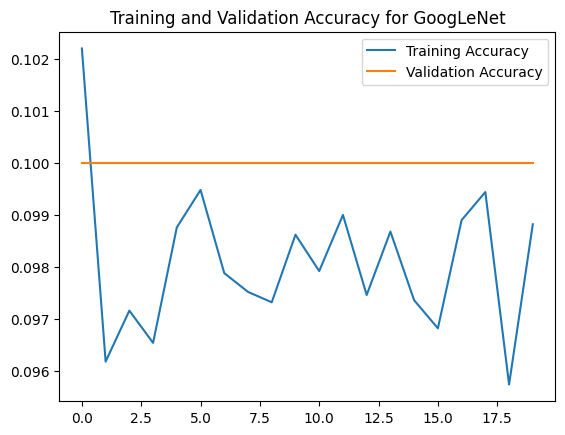

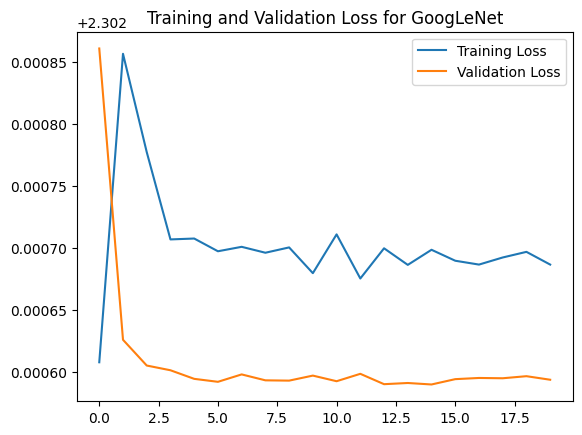

In [4]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history_googlenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_googlenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy for GoogLeNet')
plt.legend()
plt.show()

# Plot loss
plt.plot(history_googlenet.history['loss'], label='Training Loss')
plt.plot(history_googlenet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for GoogLeNet')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values (0 to 255) to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


In [ ]:
def build_alexnet(input_shape=(32, 32, 3), num_classes=10):
    model = tf.keras.Sequential([x
        # First Convolutional Layer
        tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        # Second Convolutional Layer
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        # Third Convolutional Layer
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),

        # Fourth Convolutional Layer
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        # Flatten the output
        tf.keras.layers.Flatten(),

        # Fully Connected Layer 1
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        # Fully Connected Layer 2
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        # Output Layer
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Function to calculate performance metrics and loss
def evaluate_model(model, x_test, y_test):
    # Predict on test set
    y_pred = model.predict(x_test)
    y_pred_classes = y_pred.argmax(axis=1)
    y_true = y_test.argmax(axis=1)

    # Calculate accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='macro')
    recall = recall_score(y_true, y_pred_classes, average='macro')
    f1 = f1_score(y_true, y_pred_classes, average='macro')

    # Print classification report
    print(classification_report(y_true, y_pred_classes))

    # Return metrics as a dictionary
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# Function to plot loss curves
def plot_loss_curves(history, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot performance metrics
def plot_metrics(metrics_dict, model_name):
    metrics_names = list(metrics_dict.keys())
    metrics_values = list(metrics_dict.values())

    plt.figure(figsize=(8, 5))
    plt.bar(metrics_names, metrics_values, color=['skyblue', 'lightgreen', 'salmon', 'purple'])
    plt.title(f'Performance Metrics for {model_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    for i, v in enumerate(metrics_values):
        plt.text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()



In [ ]:
alexnet_model = build_alexnet(input_shape=(32, 32, 3), num_classes=10)
alexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_alexnet = alexnet_model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_test, y_test)
)


Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 529s 1s/step - accuracy: 0.2587 - loss: 1.9458 - val_accuracy: 0.5403 - val_loss: 1.2707
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 568s 1s/step - accuracy: 0.5413 - loss: 1.2711 - val_accuracy: 0.6526 - val_loss: 1.0026
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 530s 1s/step - accuracy: 0.6507 - loss: 1.0033 - val_accuracy: 0.6984 - val_loss: 0.8620
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 563s 1s/step - accuracy: 0.7186 - loss: 0.8175 - val_accuracy: 0.7301 - val_loss: 0.7825
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 531s 1s/step - accuracy: 0.7608 - loss: 0.6975 - val_accuracy: 0.7453 - val_loss: 0.7545
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 560s 1s/step - accuracy: 0.7954 - loss: 0.5966 - val_accuracy: 0.7578 - val_loss: 0.7307
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 556s 1s/step - accuracy: 0.8257 - loss: 0.5125 - val_accuracy: 0.7656 - val_loss: 0.7319
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 562s 1s/step - accuracy: 0.8514 - loss: 0.4316 - val_accu

313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 112ms/step
              precision    recall  f1-score   support

           0       0.80      0.75      0.78      1000
           1       0.88      0.85      0.87      1000
           2       0.71      0.65      0.68      1000
           3       0.57      0.59      0.58      1000
           4       0.74      0.68      0.71      1000
           5       0.66      0.65      0.65      1000
           6       0.84      0.80      0.82      1000
           7       0.74      0.84      0.79      1000
           8       0.81      0.90      0.85      1000
           9       0.82      0.85      0.83      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.75     10000
weighted avg       0.76      0.76      0.75     10000

{'accuracy': 0.7556, 'precision': 0.7564869239254712, 'recall': 0.7556, 'f1_score': 0.7549714903756801}


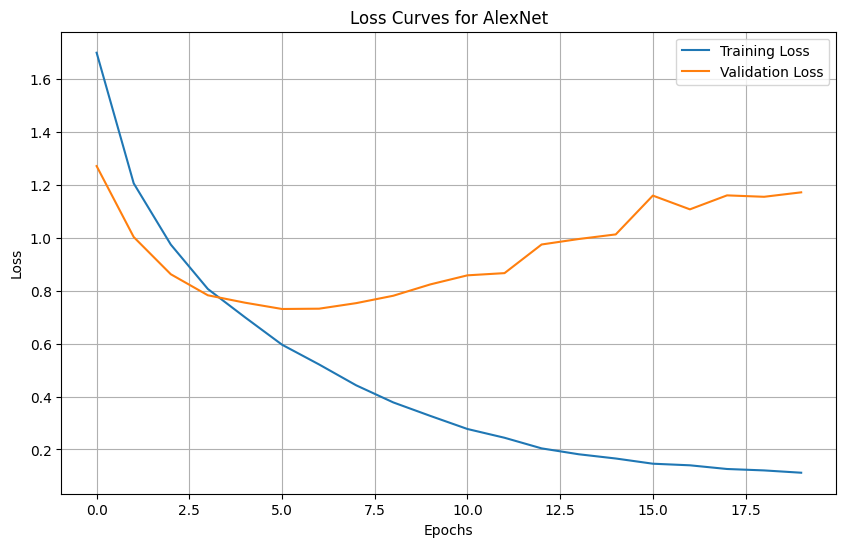

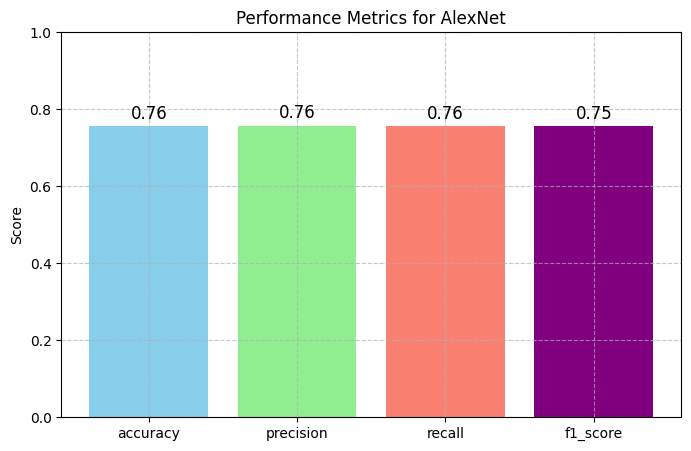

In [ ]:
metrics_alexnet = evaluate_model(alexnet_model, x_test, y_test)
print(metrics_alexnet)
plot_loss_curves(history_alexnet, "AlexNet")
plot_metrics(metrics_alexnet, "AlexNet")

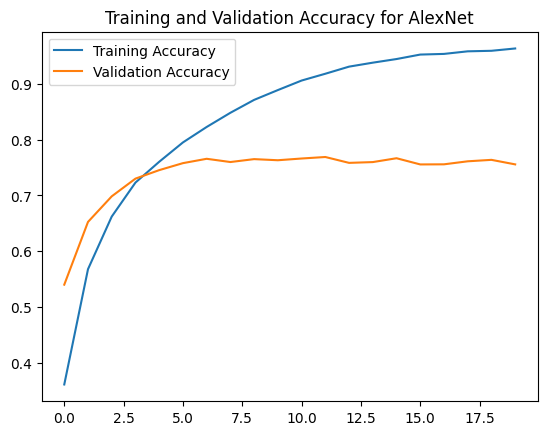

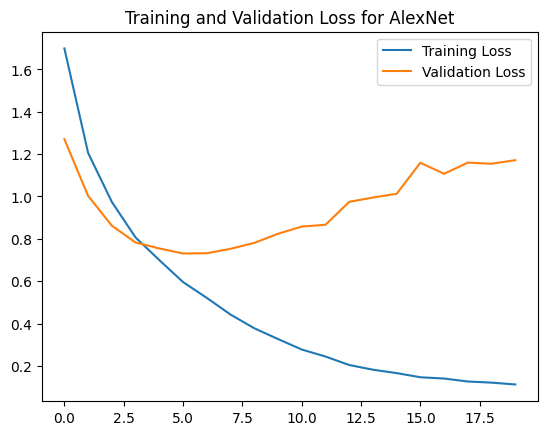

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history_alexnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_alexnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy for AlexNet')
plt.legend()
plt.show()

# Plot loss
plt.plot(history_alexnet.history['loss'], label='Training Loss')
plt.plot(history_alexnet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for AlexNet')
plt.legend()
plt.show()
